# This notebook compiles the Fish Island Data and Post-processes it

In [1]:
import os
import scipy.stats as stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import pytz
from sklearn.utils import resample
%matplotlib notebook
import warnings
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor as MPR
from sklearn.preprocessing import Normalizer,StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from scipy.optimize import curve_fit
from matplotlib.ticker import NullFormatter
import Data_Processor as DP
import importlib
importlib.reload(DP)
Root = 'C:/FishIsland_2017/'
FluxFolder='FluxResults/Test/'
TenHz_Path = Root+FluxFolder+'10Hz/eddypro_10Hz_full_output_2020-08-20T121146_exp.csv'
# TenHz_Path = Root+FluxFolder+'Downsampled/eddypro_DownSampled_full_output_2021-06-10T115019_exp.csv'
OneHz_Path = Root+FluxFolder+'1Hz/eddypro_1Hz_full_output_2020-08-20T183544_exp.csv'
Met_Path = Root+'MetStationData/CR1000_ClimateData.txt'
Soil_Path = Root+'SoilStationData/Soil_Data.csv'
Taglu_Data = Root+'TagluStationData/TagluRecord.csv'
Daytime = 'Daytime.csv'
NARRData = Root+'NARRData.csv'
Comp = DP.Compile([TenHz_Path,OneHz_Path],Met_Path,Soil_Path,Daytime,Taglu_Data,NARRData,
                  Drop_Variables = ['daytime','none_flux','qc_none_flux','none_v-adv','none_molar_density',
                    'none_mole_fraction' ,'none_mixing_ratio','none_time_lag','none_spikes',
                    'none_var','w/none_cov','x_peak','x_offset','x_10%','x_30%','x_50%','x_70%','x_90%'])
Drop = [#['2017-06-01 15:00:00','2017-06-22 23:30:00'],
['2017-07-10 10:00:00','2017-07-10 15:00:00'],
['2017-07-12 12:0:00','2017-07-12 14:00:00'],
['2017-08-01 10:00:00','2017-08-01 14:00:00'],
['2017-08-21 11:00:00','2017-08-21 14:00:00'],
['2017-09-12 07:30:00','2017-09-12 15:00:00']
       ]
# for drop in Drop:
Comp.Date_Drop(Drop,'2017-06-23 00:00:00')#,Vars='All')
    

Comp.StorageCorrection()
Comp.QC_Check(2)
Rm1 = 1- Comp.Data[['co2_flux','ch4_flux']].count()/Comp.Data[['co2_raw','ch4_raw']].count().values
print('QC Filter Removal:\n',Rm1)
Comp.Rain_Check([7,0])
Rm2 = 1- Comp.Data[['co2_flux','ch4_flux']].count()/Comp.Data[['co2_raw','ch4_raw']].count().values
print('Rain Filter Removal:\n',Rm2-Rm1)
Comp.Signal_Check(20)
Rm3 = 1- Comp.Data[['co2_flux','ch4_flux']].count()/Comp.Data[['co2_raw','ch4_raw']].count().values
print('RSSI Filter Removal:\n',Rm3-Rm2)
Comp.Wind_Filter(30,35+180)
Rm4 = 1- Comp.Data[['co2_flux','ch4_flux']].count()/Comp.Data[['co2_raw','ch4_raw']].count().values
print('Wind Filter Removal:\n',Rm4-Rm3)
Comp.Spike_Removal(z_thresh=4)
Rm5 = 1- Comp.Data[['co2_flux','ch4_flux']].count()/Comp.Data[['co2_raw','ch4_raw']].count().values
print('Spike Filter Removal:\n',Rm5-Rm4)
# Comp.ustar_Bins(30,{'Var':'PPFD_Avg','Thresh':10},{'Var':'co2_flux','Plot':False},
#                 {'Repetitions':100,'n_samples':10000})
# print(Comp.uThresh)
Comp.Ustar_Drop(Override=.1)
Rm6 = 1- Comp.Data[['co2_flux','ch4_flux']].count()/Comp.Data[['co2_raw','ch4_raw']].count().values
print('u* Filter Removal:\n',Rm6-Rm5)
# Comp.Signal_Check(20)
Comp.Wind_Bins(30)
Comp.CustomVars()

# if Taglu_Data is None:

# Comp.Merge(Root)#,Vars,Aliases)


Data = Comp.Data.copy()
Data['Zm'] = 2.87
Data['Z0'] = Data['Zm']*np.exp(-.41*Data['wind_speed']/Data['u*'])
Data.index.name='datetime'

# Comp.AllData['TOD']=Comp.AllData.index.hour+Comp.AllData.index.minute/60
Comp.Data['TOD']=Comp.Data.index.hour+Comp.Data.index.minute/60
#     Vars=['fco2','ER','fch4','SoilMoist(1)','SoilMoist(2)','SoilMoist(4)','Delta_SoilMoist(4)','Total_Rainfall_Tot',
#          'AirTemp_Avg','Net_SW_Wm2_Avg','Net_LW_Wm2_Avg','Net_Ttl_Rad_Avg','WindSpd']
# Data.to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/AllData.csv')

# Data.to_csv('MostRecent.csv')
Comp.Merge()
print('Final Sample Size')

print(Data[['fco2','fch4']].count())

QC Filter Removal:
 co2_flux    0.045883
ch4_flux    0.108497
dtype: float64
Rain Filter Removal:
 co2_flux    0.000000
ch4_flux    0.002179
dtype: float64
ch4_noSSFilter    2041
ch4_flux          2041
dtype: int64
RSSI Filter Removal:
 co2_flux    0.000000
ch4_flux    0.133333
dtype: float64
Wind Filter Removal:
 co2_flux    0.083281
ch4_flux    0.071895
dtype: float64
Spike Filter Removal:
 co2_flux    0.041169
ch4_flux    0.033115
dtype: float64
u* Filter Removal:
 co2_flux    0.043683
ch4_flux    0.023094
dtype: float64


C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Final Sample Size
fco2    2501
fch4    1441
dtype: int64


In [2]:
# print(Comp.Data.loc[Comp.Data['ch4_flux'].isnull()==False])

print(Comp.Data['rssi_77_mean'])
# print(Comp.Data['ch4_noSSFilter'])

2017-06-23 00:00:00-06:00    55.766584
2017-06-23 00:30:00-06:00    55.508870
2017-06-23 01:00:00-06:00    54.769052
2017-06-23 01:30:00-06:00    55.013792
2017-06-23 02:00:00-06:00    55.181799
                               ...    
2017-09-13 10:30:00-06:00    34.636376
2017-09-13 11:00:00-06:00    34.867490
2017-09-13 11:30:00-06:00    35.158374
2017-09-13 12:00:00-06:00    35.246868
2017-09-13 12:30:00-06:00    35.220425
Freq: 30T, Name: rssi_77_mean, Length: 3962, dtype: float64


In [3]:

# Time = 14
def SunStas(LAT,LON,JD,TIME,TZ):
    F2 = JD+TIME/24-TZ/24 ## Use PD.to_julian
    G2 = (F2-2451545)/36525 #Julian Century

    I2 = (280.46646+G2*(36000.76983 + G2*0.0003032))%360 #Geom Mean Long Sun (deg)
    J2 = 357.52911+G2*(35999.05029 - 0.0001537*G2)#Geom Mean Anom Sun (deg)
    K2 = 0.016708634-G2*(0.000042037+0.0000001267*G2)#Eccent Earth Orbit
    L2 = np.sin(np.radians(J2))*(1.914602-G2*(0.004817+0.000014*G2))+np.sin(np.radians(2*J2))*(0.019993-0.000101*G2)+np.sin(np.radians(3*J2))*0.000289 #Sun Eq of Ctr
    M2 = I2+L2 #Sun True Long (deg)
    N2 = J2+L2 #Sun True Anom (deg)
    O2 = (1.000001018*(1-K2*K2))/(1+K2*np.cos(np.radians(N2))) #Sun Rad Vector (AUs)
    P2 = M2-0.00569-0.00478*np.sin(np.radians(125.04-1934.136*G2)) #Sun App Long (deg)
    Q2 = 23+(26+((21.448-G2*(46.815+G2*(0.00059-G2*0.001813))))/60)/60 #Mean Obliq Ecliptic (deg)
    R2 = Q2+0.00256*np.cos(np.radians(125.04-1934.136*G2)) #Obliq Corr (deg)
    S2 = np.radians(np.arctan2(np.cos(np.radians(R2))*np.sin(np.radians(P2)),np.cos(np.radians(P2)))) #Sun Rt Ascen (deg)
    T2 = np.degrees(np.arcsin(np.sin(np.radians(R2))*np.sin(np.radians(P2)))) #Sun Declin (deg)
    U2 = np.tan(np.radians(R2/2))*np.tan(np.radians(R2/2))# var y
    V2 = 4*np.degrees(U2*np.sin(2*np.radians(I2))-2*K2*np.sin(np.radians(J2))+4*K2*U2*np.sin(np.radians(J2))*np.cos(2*np.radians(I2))-0.5*U2*U2*np.sin(4*np.radians(I2))-1.25*K2*K2*np.sin(2*np.radians(J2))) #Eq of Time (minutes)
    W2 = np.degrees(np.arccos(np.cos(np.radians(90.833))/(np.cos(np.radians(LAT))*np.cos(np.radians(T2)))-np.tan(np.radians(LAT))*np.tan(np.radians(T2)))) #HA Sunrise (deg)

    X2 = (720-4*LON-V2+TZ*60)/1440 #Solar Noon (LST)
    Sunrise = (X2*1440-W2*4)/1440 #Sunrise Time (LST)
    Sunset = (X2*1440+W2*4)/1440 #Sunset Time (LST)

    AA2=8*W2 #Sunlight Duration (minutes)
    AB2=(TIME*1440+V2+4*LON-60*TZ)%1440 # True Solar Time (min)

    if AB2/4<0:
        AC2=AB2/4+180# Hour Angle (deg)
    else:
        AC2=AB2/4-180# Hour Angle (deg)

    Zenith = np.degrees(np.arccos(np.sin(np.radians(LAT))*np.sin(np.radians(T2))+np.cos(np.radians(LAT))*np.cos(np.radians(T2))*np.cos(np.radians(AC2))))# Solar Zenith Angle (deg)

    # np.degrees(ACOS(SIN(np.radians($B$2))*SIN(np.radians(T2))+COS(np.radians($B$2))*COS(np.radians(T2))*COS(np.radians(AC2))))

    Angle = 90-Zenith #Solar Elevation Angle (deg)
#     AF2 = 0/3600
    if Angle>85:
        AF2 = 0
    elif Angle>5:
        AF2 = 58.1/np.tan(np.radians(Angle))-0.07/((np.tan(np.radians(Angle)))**3)+0.000086/(np.tan(np.radians(Angle))**5)
    elif Angle>-0.575:
        AF2 = 1735+Angle*(-518.2+Angle*(103.4+Angle*(-12.79+Angle*0.711)))
    else:
        AF2 = -20.772/np.tan(np.radians(Angle))
    AF2/=3600#pprox Atmospheric Refraction (deg)
    Angle_Corr = Angle+AF2 #Solar Elevation corrected for atm refraction (deg)

    if AC2>0:
        Azimuth = (np.degrees(np.arccos(((np.sin(np.radians(LAT))*np.cos(np.radians(Zenith)))-np.sin(np.radians(T2)))/(np.cos(np.radians(LAT))*np.sin(np.radians(Zenith)))))+180)%360
    else:
        Azimuth = (540-np.degrees(np.arccos(((np.sin(np.radians(LAT))*np.cos(np.radians(Zenith)))-np.sin(np.radians(T2)))/(np.cos(np.radians(LAT))*np.sin(np.radians(Zenith))))))%360
    # Solar Azimuth Angle (deg cw from N)
    return(Zenith,Angle,Angle_Corr,Azimuth,Sunrise,Sunset)

# print(ws['$AE2'].value.replace('=',''))
# print(ws['$AE1'].value)
# print()



# Tagul AWS vs. Fish Island

In [4]:
Satelite=pd.read_csv('SatSun.csv',parse_dates=['Date'])
Satelite=Satelite.set_index(pd.DatetimeIndex(Satelite.Date))
Satelite['Snow'] = Satelite['Snow'].interpolate().bfill()
Satelite=Satelite.drop('DOY',axis=1)
# Satelite_30=Satelite.resample('30T').interpolate()

GapFilled=pd.read_csv('GapFilled_Fluxes.csv',parse_dates=['datetime'])
GapFilled=GapFilled.set_index(pd.DatetimeIndex(GapFilled.datetime))
# print(GapFilled)

# print(GapFilled.head())
AWS = Comp.dfTaglu[['AirTemp', 'AirTemp_Avg', 'Rainfall_Tot',
       'SoilMoist(1)', 'SoilMoist(2)', 'SoilMoist(3)', 'SoilMoist(4)',
       'SoilMoist(5)', 'SoilMoist(6)', 'Net_SW_Wm2_Avg', 'Net_LW_Wm2_Avg',
       'Net_Ttl_Rad_Avg', 'WindSpd', 'WindDir', 
                    'Total_Rainfall_Tot']].resample('30T').interpolate()


Data = Comp.Data.drop(['AirTemp', 'AirTemp_Avg', 'Rainfall_Tot',
       'SoilMoist(1)', 'SoilMoist(2)', 'SoilMoist(3)', 'SoilMoist(4)',
       'SoilMoist(5)', 'SoilMoist(6)', 'Net_SW_Wm2_Avg', 'Net_LW_Wm2_Avg',
       'Net_Ttl_Rad_Avg', 'WindSpd', 'WindDir', 
                    'Total_Rainfall_Tot'],axis=1)



AWS = AWS.loc[:,~AWS.columns.duplicated()]
Data = Data.join(AWS,how='outer')
Data = Data.join(GapFilled,how='outer')
Data = Data.drop('Daytime',axis=1)
idx = Data.index.rename('datetime')
Data=Data.set_index(idx.tz_localize(None))
# print(Data)
Data = Data.join(Satelite,how='inner')
print(Data.head())

Data.index=Data.index.rename('datetime')

Data = Data.rename(columns={'NEE':'NEE_GapGilled','NME':'NME_GapGilled'})

# Data['MaxAngle'] = Data.groupby(Data.index.day)['Angle'].transform('max')
cols =['fch4','fco2','ch4_flux','co2_flux','ER','Daytime','AirTemp_Avg', 'Rainfall_Tot','SoilMoist(4)',
       'Net_SW_Wm2_Avg', 'Net_LW_Wm2_Avg','Net_Ttl_Rad_Avg', 'WindSpd', 'WindDir','DOY',
       'Daytime','DSSM','NDVI','Angle','NEE_GapGilled','NME_GapGilled']
Data[cols].to_csv('Down_Sampled.csv')


                     DOY  file_records  used_records  Tau  qc_Tau  \
2008-08-27 19:00:00  NaN           NaN           NaN  NaN     NaN   
2008-08-27 19:30:00  NaN           NaN           NaN  NaN     NaN   
2008-08-27 20:00:00  NaN           NaN           NaN  NaN     NaN   
2008-08-27 20:30:00  NaN           NaN           NaN  NaN     NaN   
2008-08-27 21:00:00  NaN           NaN           NaN  NaN     NaN   

                     rand_err_Tau   H  qc_H  rand_err_H  LE  ...  SnowFree  \
2008-08-27 19:00:00           NaN NaN   NaN         NaN NaN  ...       NaN   
2008-08-27 19:30:00           NaN NaN   NaN         NaN NaN  ...       NaN   
2008-08-27 20:00:00           NaN NaN   NaN         NaN NaN  ...       NaN   
2008-08-27 20:30:00           NaN NaN   NaN         NaN NaN  ...       NaN   
2008-08-27 21:00:00           NaN NaN   NaN         NaN NaN  ...       NaN   

                     SnowFree_Interp  NDVI_MODIS_Interp  Snow       DSSM  \
2008-08-27 19:00:00              NaN    

Cent. 10cm    0.746131
Cent. 20cm    0.899278
Cent. 40cm    0.997885
Rim 10cm      0.985740
Rim 20cm      1.000000
Rim 40cm      0.633588
dtype: float64


<IPython.core.display.Javascript object>


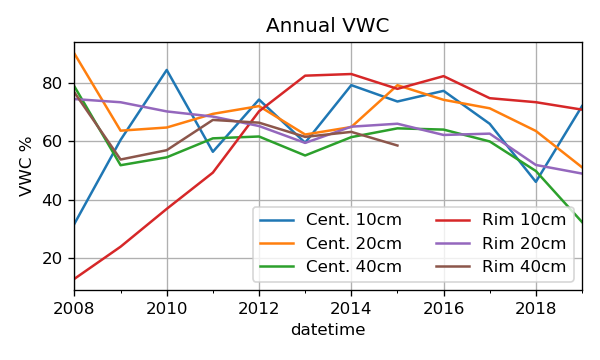

<IPython.core.display.Javascript object>


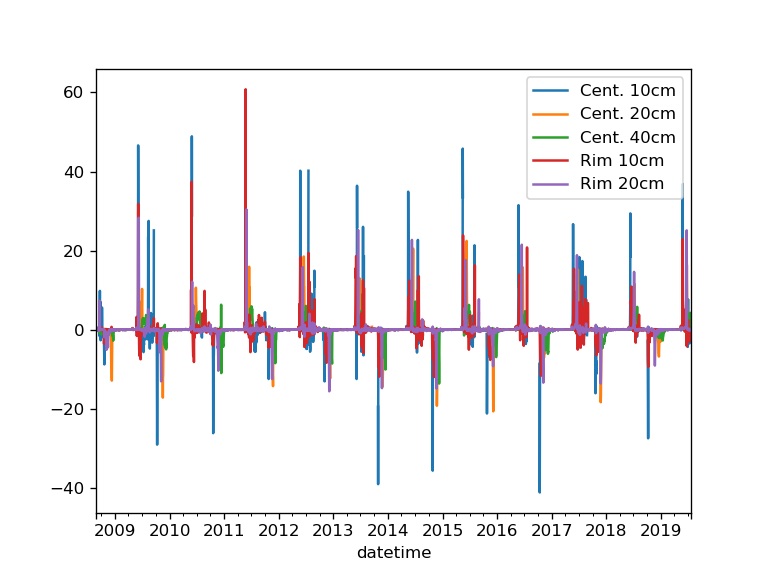

In [5]:



T30 = Comp.dfTaglu.copy()

T30 = T30.rename(columns={'SoilMoist(1)':'Cent. 10cm',
                          'SoilMoist(2)':'Cent. 20cm',
                          'SoilMoist(3)':'Cent. 40cm',
                          'SoilMoist(4)':'Rim 10cm',
                          'SoilMoist(5)':'Rim 20cm',
                          'SoilMoist(6)':'Rim 40cm'}
                 )
print(T30[['Cent. 10cm',
'Cent. 20cm',
'Cent. 40cm',
'Rim 10cm',
'Rim 20cm',
'Rim 40cm'
                 ]].count()/T30.count()['RECORD'])
fig,ax = plt.subplots(figsize=(5,3))
T30.loc[((T30.index.month>5)&(T30.index.month<10)),['Cent. 10cm',
'Cent. 20cm',
'Cent. 40cm',
'Rim 10cm',
'Rim 20cm',
'Rim 40cm'
                                                         ]].resample('Y').mean().plot(ax=ax)
ax.set_title('Annual VWC')
ax.set_ylabel('VWC %')
ax.grid()
ax.legend(ncol=2)
plt.tight_layout()
plt.savefig('AnualVWC.png')

# T30['DOY']=T30.index.dayofyear
Max = T30[['Cent. 10cm',
'Cent. 20cm',
'Cent. 40cm',
'Rim 10cm',
'Rim 20cm',
# 'Rim 40cm'
 ]].resample('D').max()

Max.diff().plot()




Daytime
0     164
1    1277
Name: fch4, dtype: int64
Daytime
0     302
1    2199
Name: fco2, dtype: int64


<IPython.core.display.Javascript object>


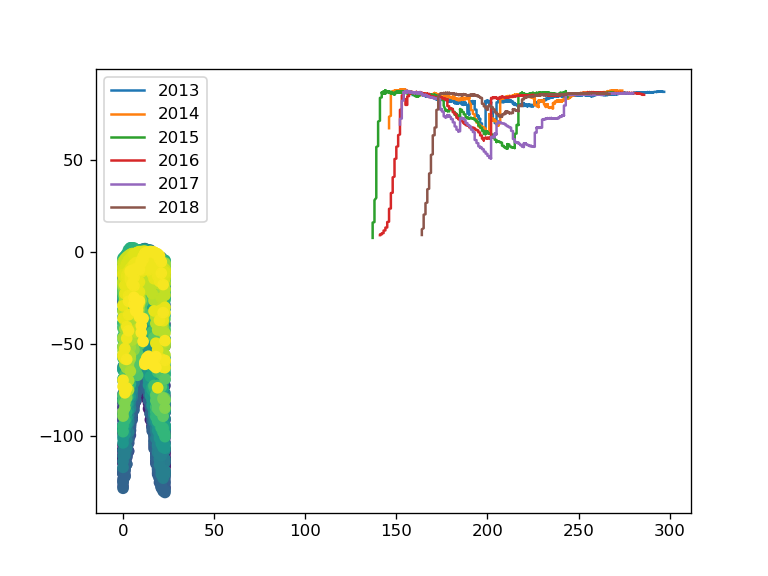

Index(['RECORD', 'AirTemp', 'AirTemp_Avg', 'Rainfall_Tot', 'SoilMoist(1)',
       'SoilMoist(2)', 'SoilMoist(3)', 'SoilMoist(4)', 'SoilMoist(5)',
       'SoilMoist(6)', 'Net_SW_Wm2_Avg', 'Net_LW_Wm2_Avg', 'Net_Ttl_Rad_Avg',
       'WindSpd', 'WindDir', 'Unnamed: 16', 'Unnamed: 17',
       'Delta_SoilMoist(4)', 'Delta_SoilMoist(5)', 'Total_Rainfall_Tot'],
      dtype='object')

In [6]:
# from datetime import datetime as dt
# LAT = 69.36666
# LON = -134.86
# TZ = -7
# Data = Data.loc[((Data.index.year==2017)&(Data.index.month>=9)&(Data.index.month<=9))]
# JD = 2457927.5
# i = 0
# Data['Angle'] = np.nan
# Data['Azimuth'] = np.nan
# Data['Zenith'] = np.nan
# # Data['Dark']=0
# for index,JD,HOUR in zip(Data.index.values,pd.DatetimeIndex(Data.index.date).to_julian_date().values,Data.index.hour.values):
#     TIME=HOUR/24
#     print(TIME)
#     Zenith,Angle,Angle_Corr,Azimuth,Sunrise,Sunset = SunStas(LAT,LON,JD,TIME,TZ)
#     Data.loc[Data.index==index,'Angle'] = Angle_Corr
#     Data.loc[Data.index==index,'Sunrise'] = Sunrise
#     Data.loc[Data.index==index,'Sunset'] = Sunset
# print(Data['Sunset'],Data['Sunrise'])
print(Data.loc[np.isnan(Data['fch4'])==False].groupby('Daytime').count()['fch4'])
print(Data.loc[np.isnan(Data['fco2'])==False].groupby('Daytime').count()['fco2'])

Temp = Data.loc[Data['Snow']>=1]
# Data['Snow']
plt.figure()
for i in range(2013,2019):
    Sel = Temp.loc[Temp.index.year==i]
    plt.plot(Sel.index.dayofyear,Sel['SoilMoist(4)'],label=str(i))#.groupby(Comp.dfTaglu.index.year).count()/Comp.dfTaglu[['AirTemp']].groupby(Comp.dfTaglu.index.year).count().values
plt.legend()
Comp.dfTaglu.columns

In [7]:
# plt.figure()
# plt.plot(Data.groupby(Data.DOY).mean().)
Temp = Data.loc[((Data.index.year==2017)&(Data.index.month>=6)&(Data.index.month<=9))]
plt.scatter(Temp.index.hour,Temp.Net_LW_Wm2_Avg,c=Temp.DOY)
# YM = Data.groupby(Data.index.year).max()['DSSM']4
Data['Year']=Data.index.year
Data['Hour']=Data.index.year
print(Data.groupby('Year')['Net_LW_Wm2_Avg'])
# print(YM)
# plt.figure()
# plt.plot(Data.loc[Data.DSSM==1].index.year,Data.loc[Data.DSSM==1].index.dayofyear)
# plt.plot(Data.loc[Data.DSSM==1].index.year,Data.loc[Data.DSSM==1].index.dayofyear+)

ch4_flux          1441
ch4_noSSFilter    2041
dtype: int64


<IPython.core.display.Javascript object>


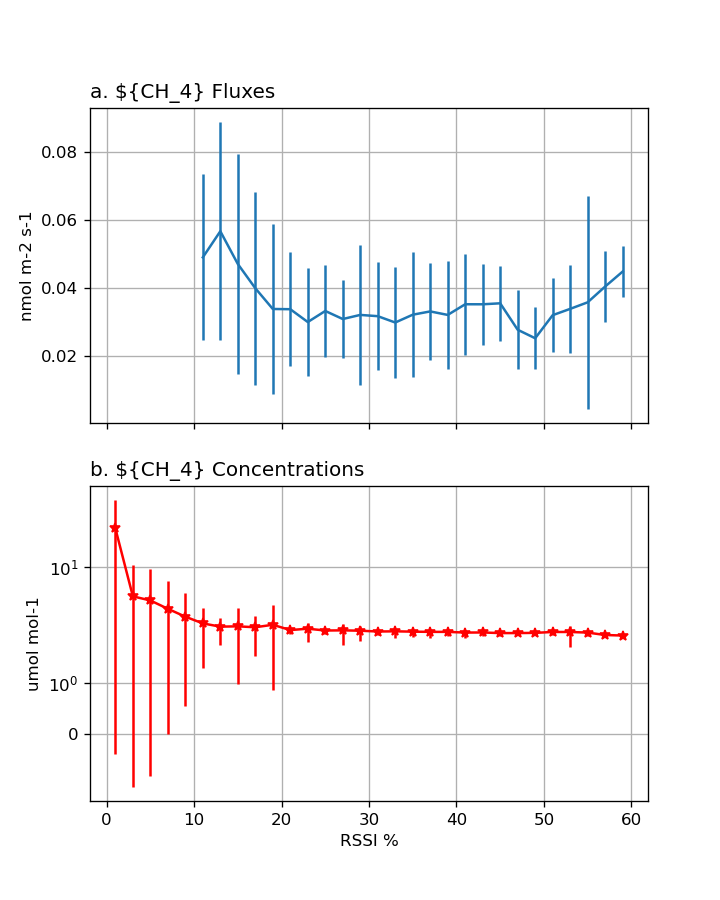

In [9]:

import matplotlib as mpl
mpl.rcParams["mathtext.default"] = 'regular'

Data = Comp.Data.copy()
print(Data[['ch4_flux','ch4_noSSFilter']].count())

Data['RSSI'] = pd.cut(Data['rssi_77_mean'],np.arange(0,65,2),labels=np.arange(0,63,2)+1)
Temp = Data.loc[Data['rssi_77_mean']>0,['ch4_mean','ch4_flux','ch4_noSSFilter','RSSI','NR_Wm2_Avg']].groupby('RSSI').mean()
# Tempd = Data[['ch4_mean','ch4_flux','RSSI','NR_Wm2_Avg']].groupby('RSSI').count()
Temps = Data[['ch4_mean','ch4_flux','ch4_noSSFilter','RSSI','NR_Wm2_Avg']].groupby('RSSI').std()
# print(Temp)
fig,ax=plt.subplots(2,1,figsize=(6,7.5),sharex=True)
ax[0].errorbar(Temp.index,Temp['ch4_noSSFilter'],yerr=Temps['ch4_noSSFilter'])
ax[0].grid()
ax[0].set_ylabel('nmol m-2 s-1')
# ax[0].set_xlabel('RSSI %')
ax[0].set_title(r'a. ${CH_4} Fluxes',loc='left')
# x2 = plt.twinx()
ax[1].set_title('b. ${CH_4} Concentrations',loc='left')
ax[1].errorbar(Temp.index,Temp['ch4_mean'],marker='*',yerr=Temps['ch4_mean'],color='r')
ax[1].set_xlabel('RSSI %')
ax[1].set_yscale('symlog')
ax[1].grid()
ax[1].set_ylabel('umol mol-1')
plt.savefig('RSSI.jpg',dpi=600)

<IPython.core.display.Javascript object>


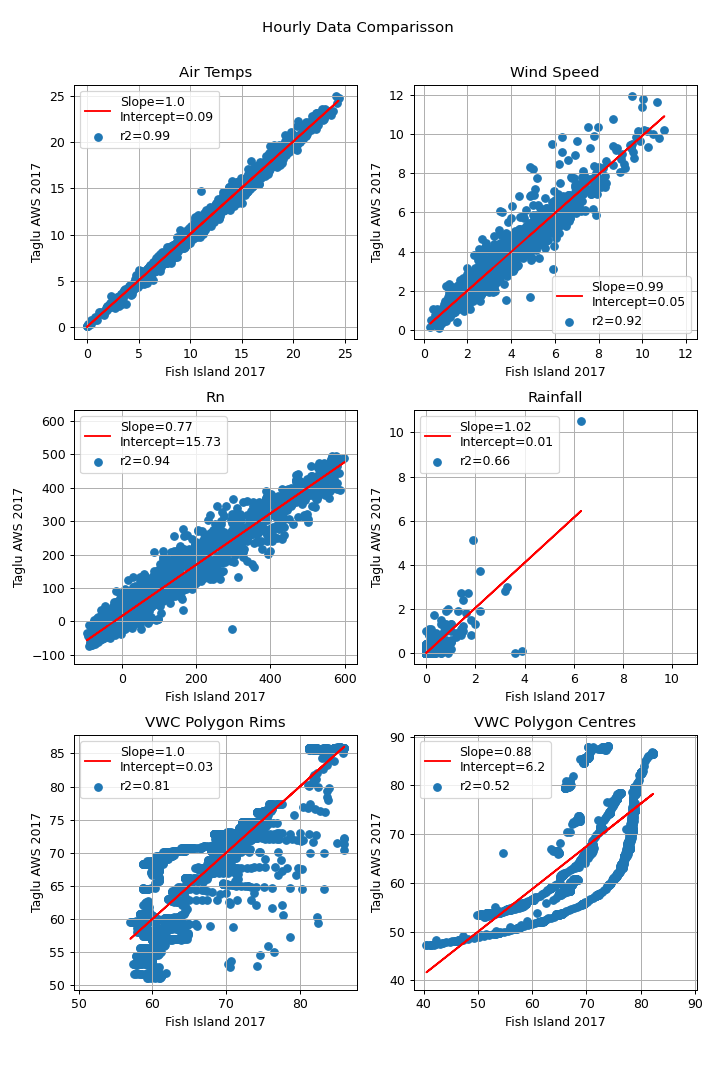

Text(0.5, 0.98, 'Hourly Data Comparisson')

In [554]:
def Plot(A,B,ax,ofs=.05,yl = 'Taglu AWS 2017'):
    Temp = GS[[A,B]].dropna()
    LR = stats.linregress(Temp[A],Temp[B])
    # print(LR)
    ax.scatter(Temp[A],Temp[B],label='r2='+str(np.round(LR[2]**2,2)))
    ax.plot(Temp[A],Temp[A]*LR[0]+LR[1],c='r',label='Slope='+str(np.round(LR[0],2))+'\n'+\
                                                                'Intercept='+str(np.round(LR[1],2)))
    ax.set_xlabel('Fish Island 2017')
    ax.set_ylabel(yl)
    mn = min(Temp[A].min(),Temp[B].min())
    mx = max(Temp[A].max(),Temp[B].max())
    
#     ax.set_yticks(ax.get_xticks())
    ax.grid()
    ax.set_ylim(mn-(mx-mn)*ofs,mx+(mx-mn)*ofs)
    ax.set_xlim(mn-(mx-mn)*ofs,mx+(mx-mn)*ofs)
    ax.legend()
    
fig,axes = plt.subplots(3,2,figsize=(8,12))

A = 'AirTC_Avg'
B = 'AirTemp_Avg'
ax = axes[0,0]
Plot(A,B,ax)
ax.set_title('Air Temps')

A = 'wind_speed'
B = 'WindSpd'
ax = axes[0,1]
Plot(A,B,ax)
ax.set_title('Wind Speed')

A = 'NR_Wm2_Avg'
B = 'Net_Ttl_Rad_Avg'
ax = axes[1,0]
Plot(A,B,ax)
ax.set_title('Rn')

A = 'Rain_mm_Tot'
B = 'Rainfall_Tot'
ax = axes[1,1]
Plot(A,B,ax)
ax.set_title('Rainfall')

A = 'VWC_2'
B = 'SoilMoist(4)'
ax = axes[2,0]
Plot(A,B,ax)
ax.set_title('VWC Polygon Rims')

A = 'VWC_1'
B = 'SoilMoist(1)'
ax = axes[2,1]
Plot(A,B,ax)
ax.set_title('VWC Polygon Centres')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Hourly Data Comparisson')

# Taglu AWS station data comparissons and patterns

<IPython.core.display.Javascript object>


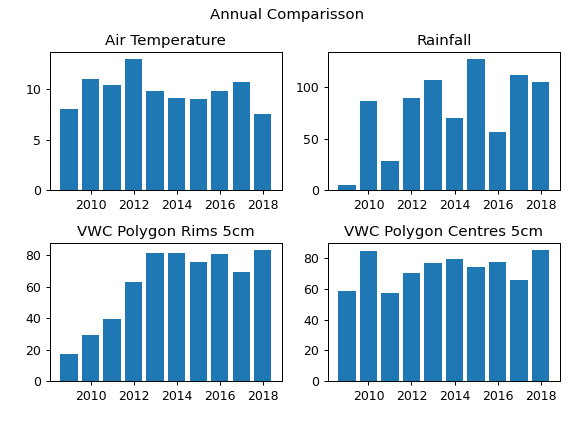

<IPython.core.display.Javascript object>


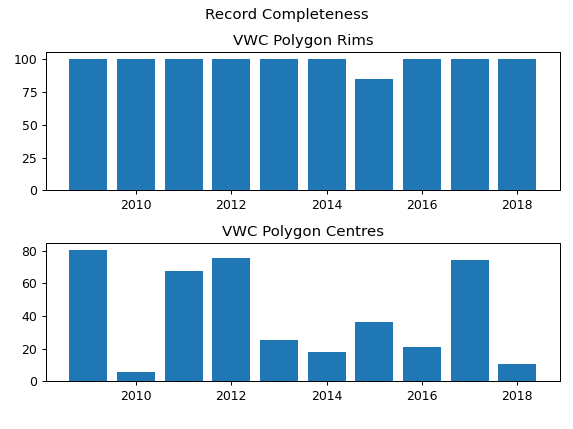

Text(0.5, 0.98, 'Record Completeness')

In [576]:
GS = Comp.AllData.loc[((Comp.AllData.index.year>2008)&(Comp.AllData.index.year<2019)&\
                       (Comp.AllData.index.dayofyear>Comp.Data.DOY.min())&(Comp.AllData.index.dayofyear<Comp.Data.DOY.max()))]

Year = GS.groupby(GS.index.year).mean()
YearC = GS.groupby(GS.index.year).count()
YearS = GS.groupby(GS.index.year).sum()
fig,ax=plt.subplots(2,2)
ax[0,0].bar(Year.index,Year['AirTemp_Avg'])
ax[0,0].set_title('Air Temperature')
ax[0,1].bar(YearS.index,YearS['Rainfall_Tot'])
ax[0,1].set_title('Rainfall')
ax[1,1].bar(Year.index,Year['SoilMoist(1)'])
ax[1,1].set_title('VWC Polygon Centres 5cm')
ax[1,0].bar(Year.index,Year['SoilMoist(4)'])
ax[1,0].set_title('VWC Polygon Rims 5cm')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Annual Comparisson')

# plt.figure()
# plt.scatter(GS.index,GS['SoilMoist(1)'],label='Cent.')
# plt.scatter(GS.index,GS['SoilMoist(4)'],label='Rim')
# plt.legend()

fig,ax=plt.subplots(2)
ax[1].bar(Year.index,YearC['SoilMoist(1)']/YearC['AirTemp_Avg']*100)
ax[1].set_title('VWC Polygon Centres')
ax[0].bar(Year.index,YearC['SoilMoist(4)']/YearC['AirTemp_Avg']*100)
ax[0].set_title('VWC Polygon Rims')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Record Completeness')





# NARR Soil temps vs. Fish Island

<IPython.core.display.Javascript object>


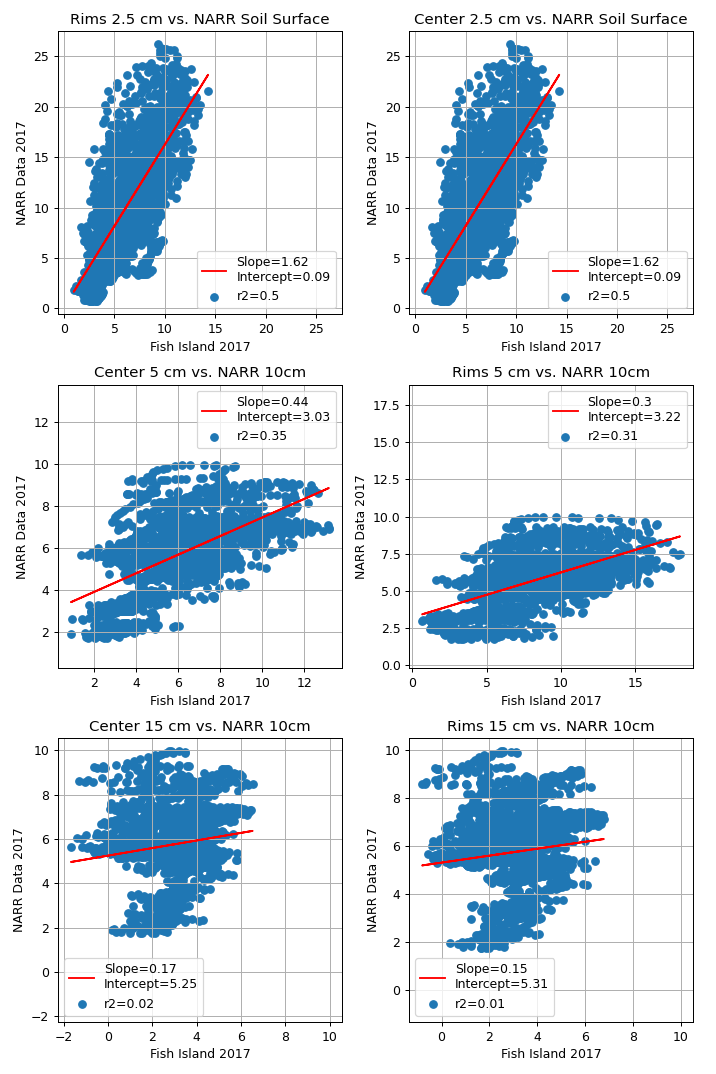

In [556]:
fig,axes=plt.subplots(3,2,figsize=(8,12))

A = 'Temp_2_5_1'
B = 'tsoil_0'
ax=axes[0,0]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Rims 2.5 cm vs. NARR Soil Surface')

A = 'Temp_2_5_1'
B = 'tsoil_0'
ax=axes[0,1]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Center 2.5 cm vs. NARR Soil Surface')

A = 'Temp_5_1'
B = 'tsoil_10'
ax=axes[1,0]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Center 5 cm vs. NARR 10cm')

A = 'Temp_5_2'
B = 'tsoil_10'
ax=axes[1,1]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Rims 5 cm vs. NARR 10cm')

A = 'Temp_15_1'
B = 'tsoil_10'
ax=axes[2,0]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Center 15 cm vs. NARR 10cm')

A = 'Temp_15_2'
B = 'tsoil_10'
ax=axes[2,1]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Rims 15 cm vs. NARR 10cm')
plt.tight_layout()


# Taglu AWS vs. NARR: VWC

<IPython.core.display.Javascript object>


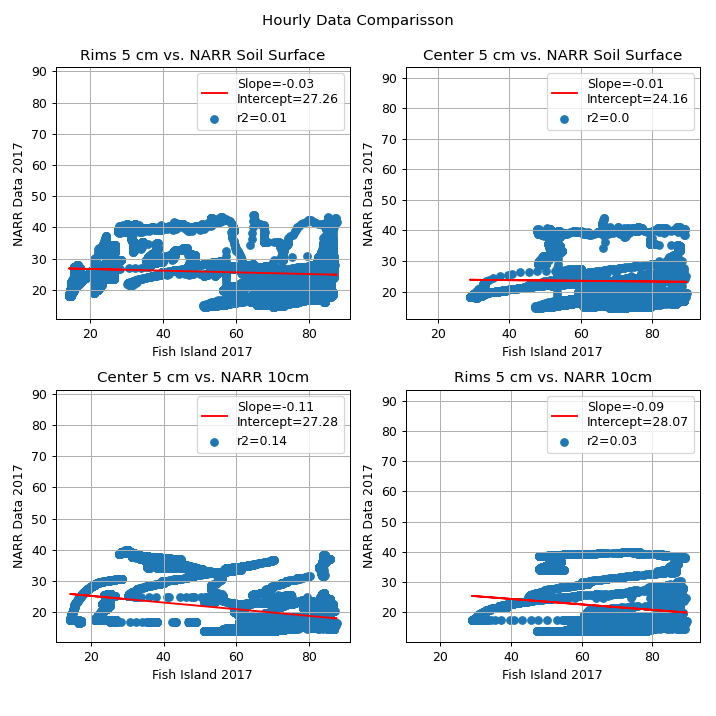

Text(0.5, 0.98, 'Hourly Data Comparisson')

In [577]:
fig,axes=plt.subplots(2,2,figsize=(8,8
                                  ))

A = 'SoilMoist(4)'
B = 'soill_0'
ax=axes[0,0]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Rims 5 cm vs. NARR Soil Surface')

A = 'SoilMoist(1)'
B = 'soill_0'
ax=axes[0,1]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Center 5 cm vs. NARR Soil Surface')

A = 'SoilMoist(4)'
B = 'soill_10'
ax=axes[1,0]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Center 5 cm vs. NARR 10cm')

A = 'SoilMoist(1)'
B = 'soill_10'
ax=axes[1,1]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Rims 5 cm vs. NARR 10cm')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Hourly Data Comparisson')

Index(['soill_0', 'tsoil_0', 'soilw_0', 'soill_10', 'tsoil_10', 'soilw_10',
       'soill_40', 'tsoil_40', 'soilw_40', 'hpbl', 'ulwrf', 'apcp', 'uwnd',
       'dlwrf', 'dswrf', 'uswrf', 'air', 'tcdc', 'pres', 'vwnd', 'Wind_Speed',
       'Wind_Dir', 'MT'],
      dtype='object')


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

<IPython.core.display.Javascript object>


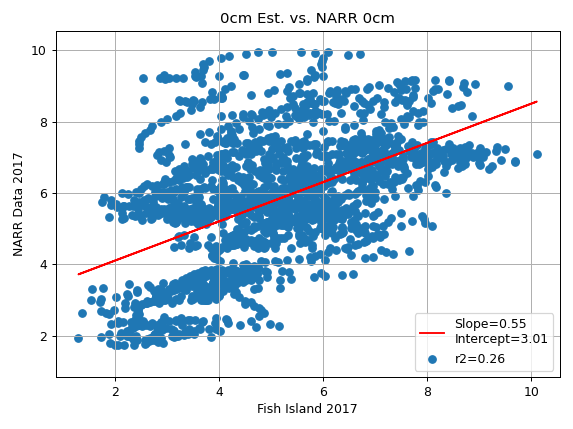

In [558]:
print(Comp.dfNARR.columns)



def Fit(X,Y,M=1):
    x=np.arange(0,41)
    if M == 2:
        z = np.polyfit(X, Y, 2)
        z0 = ((z[0]*x**2+z[1]*x+z[2])[0])
        z = np.polyfit(X, Y, 2)
        z10 = ((z[0]*x**2+z[1]*x+z[2])[10])
    else:
        z = np.polyfit(X, Y,1)
        z0 = ((z[0]*x+z[1])[0])
        z = np.polyfit(X, Y,1)
        z10 = ((z[0]*x+z[1])[10])
    return(z0,z10)
    
# V = ['Temp_2_5_1','Temp_5_1','Temp_15_1']
# X=np.array([2.5,5,15])
# V = ['Temp_2_5_2','Temp_5_2','Temp_15_2']
# X=np.array([2.5,5,15])
V = ['Temp_2_5_2','Temp_5_2','Temp_15_2','Temp_2_5_1','Temp_5_1','Temp_15_1']
X=np.array([2.5,5,15,2.5,5,15])
GS['T0']=np.nan
GS['T10']=np.nan
for i,row in GS[V].dropna().iterrows():
    GS.loc[GS.index==i,['T0','T10']]=Fit(X,row.values)

fig,ax=plt.subplots()

A = 'T10'
B = 'tsoil_10'
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('0cm Est. vs. NARR 0cm')

plt.tight_layout()


LinregressResult(slope=1.1417776206510935, intercept=0.6414773175862383, rvalue=0.9760493212115152, pvalue=4.588813168902834e-16, stderr=0.0542570560376582)


<IPython.core.display.Javascript object>


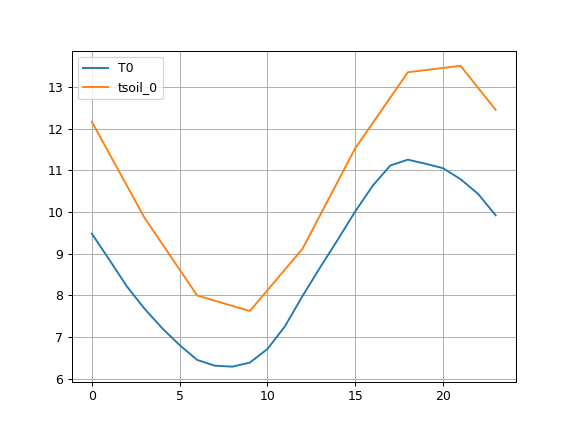

In [559]:

A = 'T0'
B = 'tsoil_0'

ax = axes[1,1]
Temp = GS[[A,B]].dropna()
Temp = Temp.groupby(Temp.index.hour).mean()
LR = stats.linregress(Temp[A],Temp[B])
print(LR)
fig,ax=plt.subplots()
Temp.plot(ax=ax)
ax.grid()




LinregressResult(slope=0.8034859538201982, intercept=11.975791357931215, rvalue=0.9874704001400941, pvalue=3.8853194298982994e-19, stderr=0.027375483468674158)


<IPython.core.display.Javascript object>


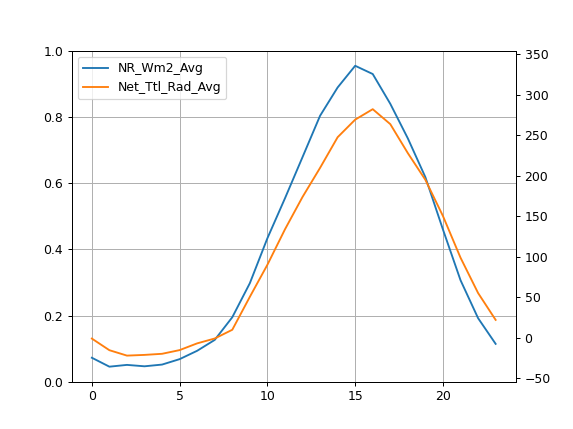

<IPython.core.display.Javascript object>


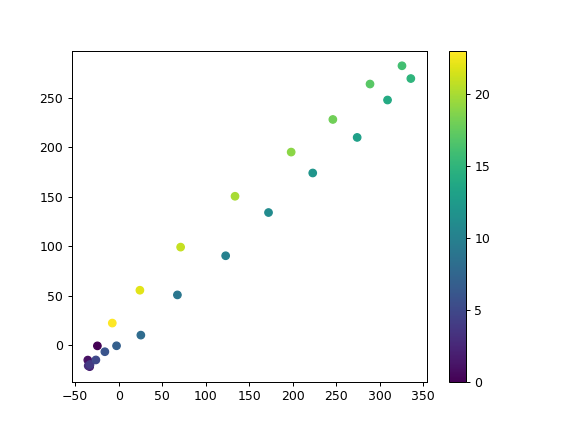

<IPython.core.display.Javascript object>


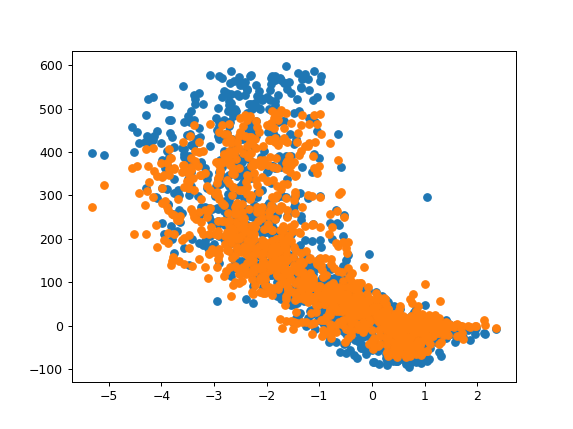

0.6138748327903523
0.6135732278728105


In [560]:

A = 'NR_Wm2_Avg'
B = 'Net_Ttl_Rad_Avg'


# A = 'VWC_2'
# B = 'SoilMoist(4)'
ax = axes[1,1]
Temp = GS[[A,B]].dropna()
# Temp = GS[[A,B,'Net_SW_Wm2_Avg', 'Net_LW_Wm2_Avg','fco2']].dropna()
Temp = Temp.groupby(Temp.index.hour).mean()
LR = stats.linregress(Temp[A],Temp[B])
print(LR)
fig,ax=plt.subplots()
# plt.plot(Temp[A],label='Fish Island')
# plt.plot(Temp[B],label='Taglu')
ax2=ax.twinx()
Temp.plot(ax=ax2)
# (-1*Temp['fco2']).plot(ax=ax,color='k')
ax.grid()



plt.legend()

plt.figure()
plt.scatter(Temp[A],Temp[B],c=Temp.index)
plt.colorbar()


plt.figure()
Temp = GS[[A,B,'fco2']].dropna()
LR = stats.linregress(Temp[A],Temp['fco2'])
print(LR[2]**2)
LR = stats.linregress(Temp[B],Temp['fco2'])
print(LR[2]**2)
plt.scatter(GS['fco2'],GS[A])
plt.scatter(GS['fco2'],GS[B])

      Rainfall_Tot        apcp
2009           5.1   47.088555
2010          87.2   95.985007
2011          28.3   30.614029
2012          89.7   65.388954
2013         107.4  103.441250
2014          70.5   83.714288
2015         127.6  120.768302
2016          56.6   65.533591
2017         111.5  134.679718
2018         105.4  106.645375


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


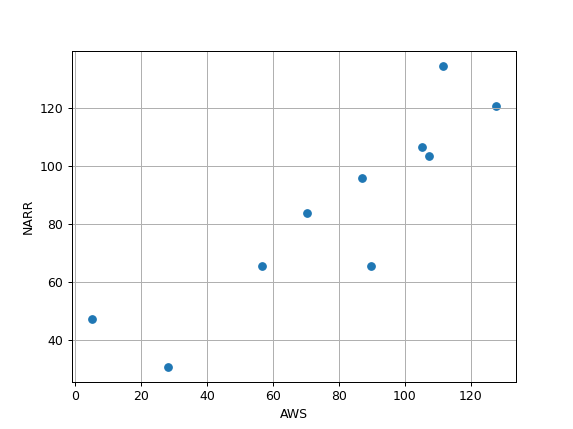

<IPython.core.display.Javascript object>


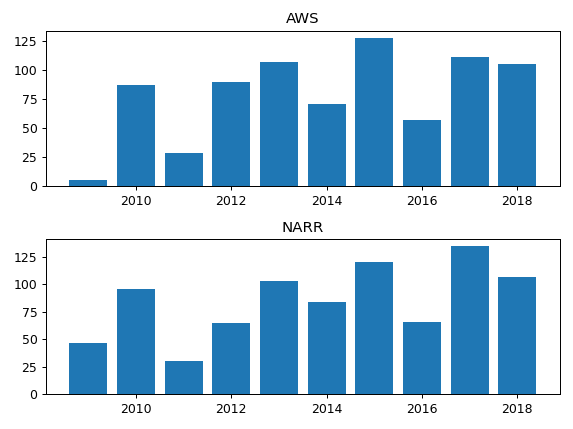

In [573]:
# print(Comp.dfNARR.columns)
GS['NR']=-GS[['ulwrf', 'uswrf']].sum(axis=1)+GS[['dlwrf', 'dswrf']].sum(axis=1)
# plt.figure()
# plt
# print(GS['NR'])

A = 'Rainfall_Tot'
B = 'apcp'
print(YearS[[A,B]])
fig,ax=plt.subplots()
ax.scatter(YearS[A],YearS[B])
ax.set_ylabel('NARR')
ax.set_xlabel('AWS')
ax.grid()

fig,ax=plt.subplots(2)
ax[0].bar(YearS.index,YearS[A])
ax[0].set_title('AWS')
ax[1].bar(YearS.index,YearS[B])
ax[1].set_title('NARR')
plt.tight_layout()

<IPython.core.display.Javascript object>


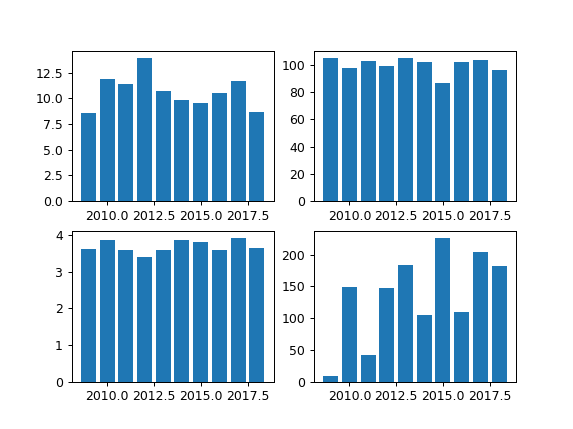

      Rain_mm_Tot  Rainfall_Tot        apcp
MT                                         
2009          0.0           9.1  278.985930
2010          0.0         148.6  429.514793
2011          0.0          42.4  101.012770
2012          0.0         148.2  272.035156
2013          0.0         183.8  473.433495
2014          0.0         105.0  366.989456
2015          0.0         225.4  540.222588
2016          0.0         109.1  328.448620
2017         91.4         203.4  699.818341
2018          0.0         182.7  529.305970


<IPython.core.display.Javascript object>


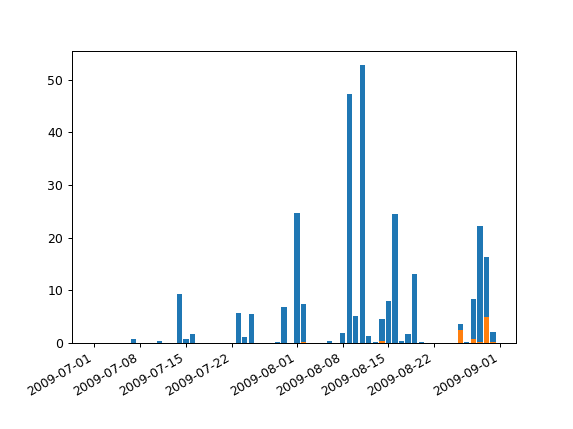

<IPython.core.display.Javascript object>


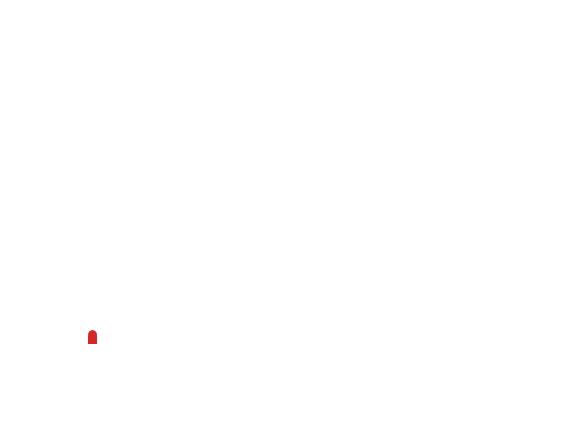

In [64]:
# Temp2 = Temp.loc[((Temp.DOY>Comp.Data['DOY'].min())&(Temp.DOY<Comp.Data['DOY'].max()))].groupby([Temp.Year]).mean()

# print(GS) 
#                        (Comp.AllData.index.dayofyear>Comp.Data['DOY'].min())&(Comp.AllData.index.dayofyear<Comp.Data['DOY'].max()))]
# print(GS)



# print(Year['AirTemp_Avg'].rank(ascending=False))
# print(Year['Net_Ttl_Rad_Avg'].rank(ascending=False))
# print(YearS[['Rainfall_Tot','apcp']].rank(ascending=False))
print(YearS[['Rain_mm_Tot','Rainfall_Tot','apcp']])
# # print(YearS[].rank(ascending=False))
# # apcp
# print(Year['WindSpd'].rank(ascending=False))
# # print(GS[''])
# print(Comp.dfTaglu.columns)
# print(Comp.dfNARR.columns)

July_Aug = 15.6+85.4


fig=plt.figure()
O9 = GS.loc[GS.index.year==2009].resample('D').sum()
# print(O9['apcp'])
plt.bar(O9.index,O9['apcp'])
plt.bar(O9.index,O9['Rainfall_Tot'])
fig.autofmt_xdate()


fig=plt.figure()
O9 = GS.loc[GS.index.year==2017].resample('D').sum()
# print(O9['apcp'])
plt.bar(O9.index,O9['apcp'])
plt.bar(O9.index,O9['Rainfall_Tot'])
plt.bar(O9.index,O9['Rain_mm_Tot'])
fig.autofmt_xdate()




3.8434979535264207
30.3002839257616
215.0 215.0
Year
2016    3.621371
2011    3.623359
2012    3.625363
2013    3.651343
2009    3.676233
2010    3.705266
2018    3.738529
2015    3.817868
2017    3.836694
2014    3.962418
Name: WindSpd, dtype: float64
Year
2018     7.516084
2009     8.053593
2015     9.002057
2014     9.055706
2013     9.754666
2016     9.906587
2011    10.350441
2017    10.689248
2010    10.960386
2012    12.957635
Name: AirTemp, dtype: float64
Year
2009    0.002623
2011    0.014558
2016    0.034439
2014    0.036265
2010    0.044856
2012    0.046142
2018    0.054218
2013    0.055247
2017    0.057356
2015    0.065638
Name: Rainfall_Tot, dtype: float64
                           RECORD  AirTemp  AirTemp_Avg  Rainfall_Tot  \
datetime                                                                
2008-08-27 13:00:00-06:00    17.0   6.4780       6.5240           0.0   
2008-08-27 13:30:00-06:00    17.5   6.5005       6.4865           0.0   
2008-08-27 14:00:00-06:00    1

<IPython.core.display.Javascript object>


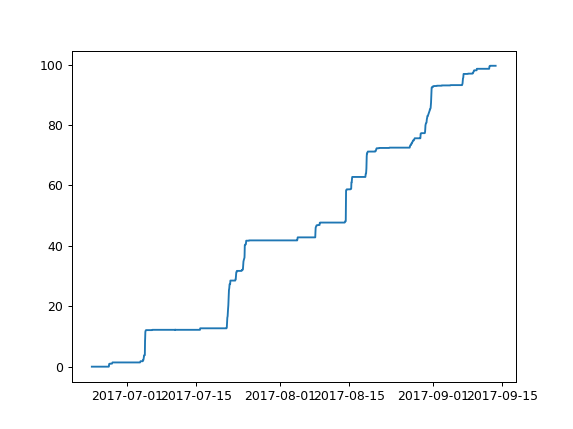

6     1.4
7    40.4
8    51.0
9     6.8
Name: Rain_mm_Tot, dtype: float64
-8.49963252547252


In [2]:

Temp = Comp.dfTaglu.copy()
Temp['Month'] = Comp.dfTaglu.index.month
Temp['Year'] = Comp.dfTaglu.index.year
Temp['DOY'] = Comp.dfTaglu.index.dayofyear
Comp.Data['DOY'] = Comp.Data.index.dayofyear
Comp.Data['Month'] = Comp.Data.index.month

print(Comp.Data['wind_speed'].mean())#*3600*1e-3)
print(Comp.Data['max_wind_speed'].max())#*3600*1e-3)
Temp = Temp.loc[((Temp.Year>2008)&(Temp.Year<2019))]

# print()
# Temp3 = Comp.Data.loc[((Comp.Data.Month==7)|
#                   (Comp.Data.Month==8))].mean()
#

# []
Temp2 = Temp.loc[((Temp.DOY>Comp.Data['DOY'].min())&(Temp.DOY<Comp.Data['DOY'].max()))].groupby([Temp.Year]).mean()

print(Temp2['DOY'].min(),Temp2['DOY'].max())

print(Temp2['WindSpd'].sort_values())
print(Temp2['AirTemp'].sort_values())
print(Temp2['Rainfall_Tot'].sort_values())
print(Comp.dfTaglu.head())


# Temp3 = Comp.Data.loc[((Comp.Data.Month==7)|
#                   (Comp.Data.Month==8))].mean()
# print(Temp3['wind_speed'])

plt.figure()
plt.plot(Comp.Data['Rain_mm_Tot'].cumsum())


print(Comp.Data.groupby(Comp.Data.index.month).sum()['Rain_mm_Tot'])



datetime
1     3.969436
2     4.012603
3     3.711906
4     4.068017
5     4.114678
6     3.983486
7     3.734835
8     3.617669
9     3.673978
10    3.478187
11    3.609169
12    3.621706
Name: WindSpd, dtype: float64
6    4.649017
7    4.153029
8    3.617582
9    3.165464
Name: wind_speed, dtype: float64


<IPython.core.display.Javascript object>


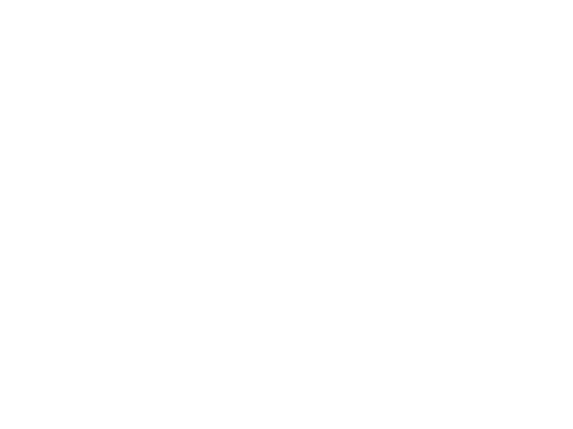

AttributeError: 'Int64Index' object has no attribute 'hour'

In [5]:


plt.figure()
Temp = Temp.groupby(Temp.index.hour).mean()
plt.plot(Temp['Net_Ttl_Rad_Avg'])
Temp = Comp.dfTaglu.loc[Comp.dfTaglu.index.month==2]
Temp = Temp.groupby(Temp.index.hour).mean()
plt.plot(Temp['Net_Ttl_Rad_Avg'])



# Comp.dfNARR['MT'] = Comp.dfNARR.index.tz_localize(pvytz.utc).tz_convert()
# Comp.dfTaglu.index.tz_localize(Comp.Mt,ambiguous=True,nonexistent='NaT')
# [Comp.Mt.localize(I).astimezone(pytz.utc) for I in Comp.dfTaglu.index]
# import pytz
# # Comp.dfNARR['MT'] = Comp.dfNARR.index.tz_localize(pytz.utc).tz_convert(pytz.timezone('US/Mountain'))
# Comp.Data['UTC'].values
# print(Comp.dfNARR)
# plt.figure()
# print(Comp.Data['Net_Ttl_Rad_Avg'])
Comp.Data['dNR']=Comp.Data[['dlwrf','dswrf']].sum(axis=1)

Comp.Data['uNR']=-Comp.Data[['ulwrf','uswrf']].sum(axis=1)
# plt.plot(Comp.Data['NR'])
# plt.plot(Comp.Data['Net_Ttl_Rad_Avg'])
# plt.plot(Comp.Data['NR_Wm2_Avg'])

# Temp = Comp.Data[['NR','Net_Ttl_Rad_Avg','NR_Wm2_Avg']].dropna()
# # print(Temp)
# plt.figure()
# plt.scatter(Temp['NR_Wm2_Avg'],Temp['NR'])
Comp.Data.Time=Comp.Data.index.hour
Temp = Comp.Data.groupby('Time').mean()[['dNR','uNR','Net_Ttl_Rad_Avg','NR_Wm2_Avg']]

plt.figure()
# plt.plot()
plt.plot(Temp['uNR']+Temp['dNR'])
plt.plot(Temp['Net_Ttl_Rad_Avg'])
plt.plot(Temp['NR_Wm2_Avg'])
plt.grid()
# print(Comp.Data['UTC'][:60])

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)

# print(Comp)
V = 'PPFD_Avg'
Inputs = ['TOD','DOY','ulwrf', 'dlwrf', 'dswrf', 'uswrf','pres','tcdc']
AllPuts=Inputs.copy()
AllPuts.append(V)
Temp = Comp.Data[AllPuts].dropna()

X = Temp[Inputs].values
y = Temp[V].values


kf.get_n_splits(X)

# print(kf)
Comp.AllData['DOY']=Comp.AllData.index.dayofyear
KF = []
KF_All = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regr = RandomForestRegressor(max_depth=10, random_state=0)
    regr.fit(X_train, y_train)
    KF.append(regr.predict(Comp.Data[Inputs]))
    KF_All.append(regr.predict(Comp.AllData[Inputs]))
    print(regr.score(X_test,y_test))
    print(regr.feature_importances_)
Comp.Data[V+'_Modeled']=np.array(KF).mean(axis=0)
Comp.AllData[V+'_Modeled']=np.array(KF_All).mean(axis=0)
plt.figure()
plt.plot(Comp.Data[V+'_Modeled'])

# print(np.array(KF).mean(axis=0).shape)



NameError: name 'Comp' is not defined

<IPython.core.display.Javascript object>


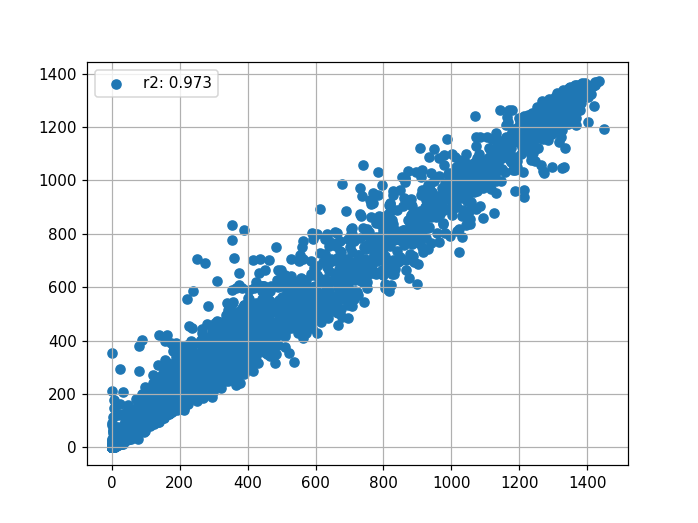

LinregressResult(slope=0.9431720262991768, intercept=19.218694353500666, rvalue=0.9862447422222073, pvalue=0.0, stderr=0.0025231154739680946)


<IPython.core.display.Javascript object>


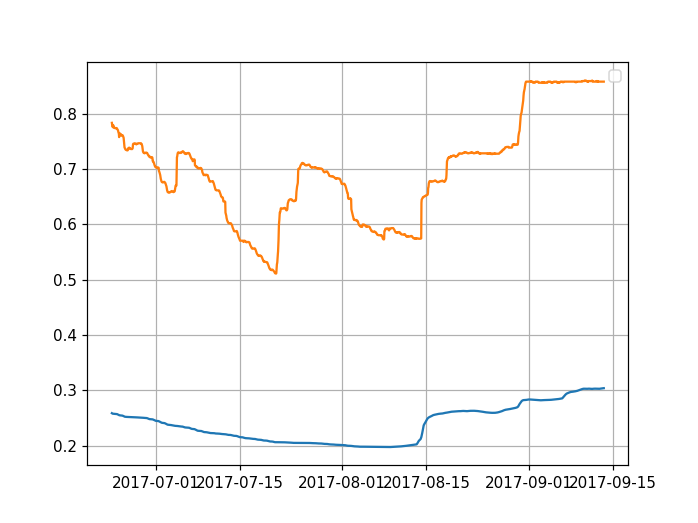

No handles with labels found to put in legend.


datetime
2017-06-23 15:00:00    0.258591
2017-06-23 15:30:00    0.258439
2017-06-23 16:00:00    0.258287
2017-06-23 16:30:00    0.258135
2017-06-23 17:00:00    0.257983
                         ...   
2017-09-13 10:30:00    0.303680
2017-09-13 11:00:00    0.303705
2017-09-13 11:30:00    0.303731
2017-09-13 12:00:00    0.303757
2017-09-13 12:30:00    0.303784
Freq: 30T, Name: soill_10, Length: 3932, dtype: float64 datetime
2017-06-23 15:00:00    78.350
2017-06-23 15:30:00    78.185
2017-06-23 16:00:00    78.020
2017-06-23 16:30:00    77.885
2017-06-23 17:00:00    77.750
                        ...  
2017-09-13 10:30:00    85.800
2017-09-13 11:00:00    85.800
2017-09-13 11:30:00    85.800
2017-09-13 12:00:00    85.800
2017-09-13 12:30:00    85.800
Freq: 30T, Name: SoilMoist(4), Length: 3932, dtype: float64


<IPython.core.display.Javascript object>


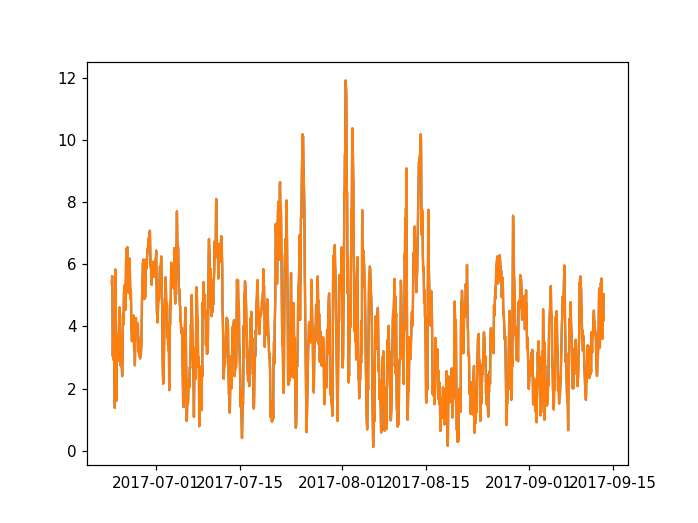

In [26]:
from scipy.stats import stats
plt.figure()
Temp = Comp.AllData[['PPFD_Avg','PPFD_Avg_Modeled']].dropna()
LR = stats.linregress(Temp['PPFD_Avg'],Temp['PPFD_Avg_Modeled'])
print(LR)
plt.scatter(Comp.AllData['PPFD_Avg'],Comp.AllData['PPFD_Avg_Modeled'],label='r2: '+str(np.round(LR[2]**2,3)))
plt.legend()
plt.grid()


In [8]:

Comp.Data.to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/AllData.csv')
Comp.AllData.to_csv('C:/Users/wesle/NetworkAnalysis/FishIsland/FullDataset.csv')
# else:

[[1.         0.96186736]
 [0.96186736 1.        ]]
-2.098242356254585e-16


<IPython.core.display.Javascript object>


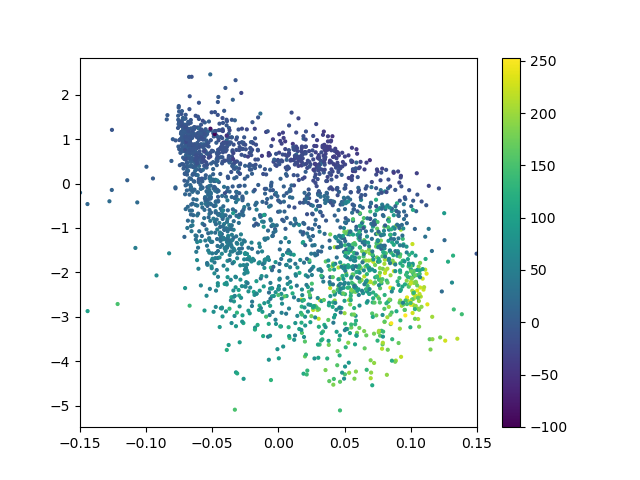

<IPython.core.display.Javascript object>


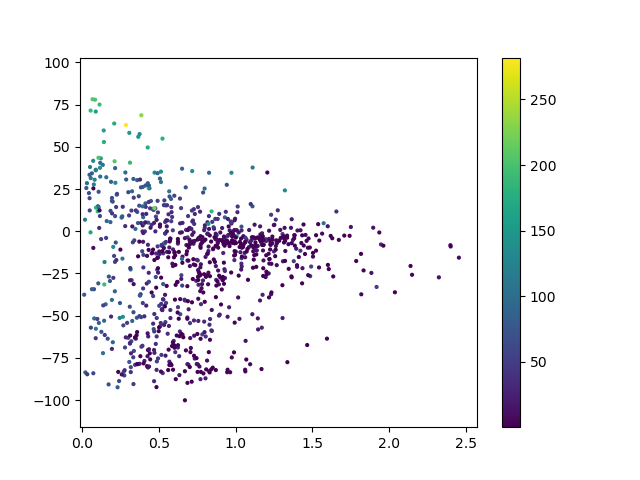

<IPython.core.display.Javascript object>


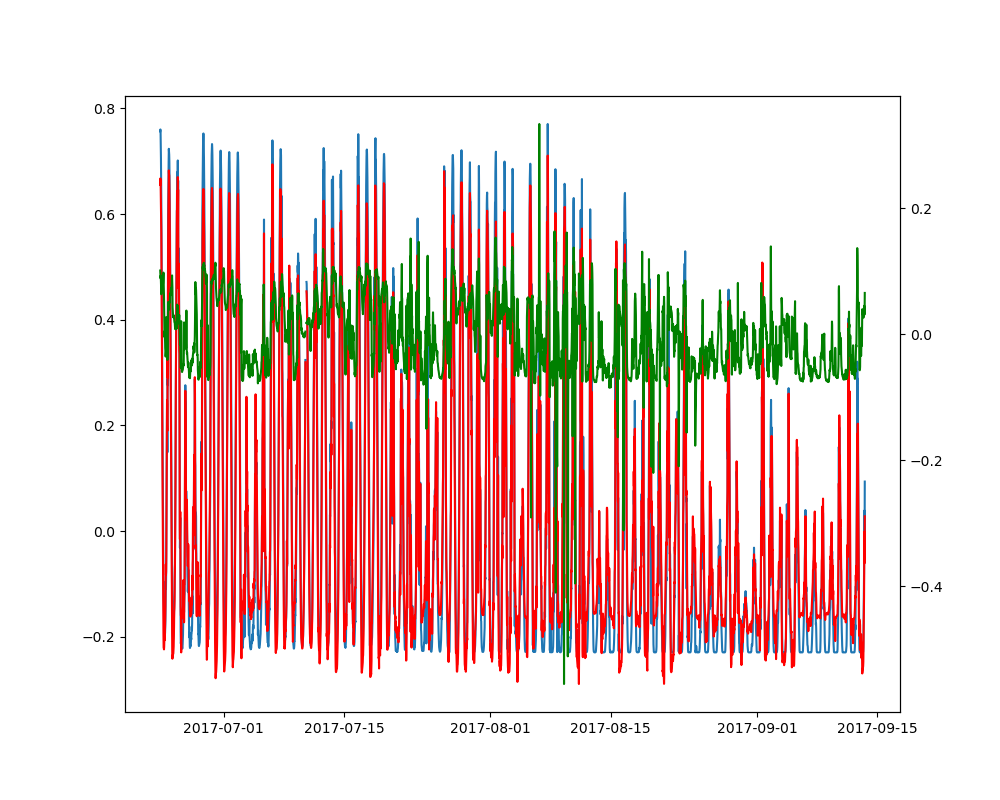

In [74]:
Temp = Data[['PPFD_Avg','NR_Wm2_Avg']].dropna()
print(np.corrcoef(Temp['PPFD_Avg'],Temp['NR_Wm2_Avg'])**2)
# Temp = Data.copy()
print(((Data['PPFD_Avg']-Data['PPFD_Avg'].mean())/(Data['PPFD_Avg'].max()-Data['PPFD_Avg'].min())-\
            (Data['NR_Wm2_Avg']-Data['NR_Wm2_Avg'].mean())/(Data['NR_Wm2_Avg'].max()-Data['NR_Wm2_Avg'].min())).mean())
# print((Data['PPFD_Avg']-Data['PPFD_Avg'].min())/(Data['PPFD_Avg'].max()-Data['PPFD_Avg'].min())
plt.figure()
plt.scatter((Data['PPFD_Avg']-Data['PPFD_Avg'].mean())/(Data['PPFD_Avg'].max()-Data['PPFD_Avg'].min())-\
            (Data['NR_Wm2_Avg']-Data['NR_Wm2_Avg'].mean())/(Data['NR_Wm2_Avg'].max()-Data['NR_Wm2_Avg'].min()),
            Data['co2_flux'],
           c = Data['H'],
           s=4)
plt.colorbar()
plt.xlim(-.15,.15)
Temp = Data.loc[Data['co2_flux']>0]
plt.figure()
plt.scatter(Temp['co2_flux'],
            Temp['NR_Wm2_Avg'],
            c=Temp['PPFD_Avg'],
           s=4)
plt.colorbar()

plt.figure(figsize=(10,8))
# plt.plot(Data['PPFD_Avg'])


plt.plot((Data['PPFD_Avg']-Data['PPFD_Avg'].mean())/(Data['PPFD_Avg'].max()-Data['PPFD_Avg'].min()))
plt.plot((Data['NR_Wm2_Avg']-Data['NR_Wm2_Avg'].mean())/(Data['NR_Wm2_Avg'].max()-Data['NR_Wm2_Avg'].min()),c='r')

x2=plt.twinx()
x2.plot(((Data['PPFD_Avg']-Data['PPFD_Avg'].mean())/(Data['PPFD_Avg'].max()-Data['PPFD_Avg'].min())-\
            (Data['NR_Wm2_Avg']-Data['NR_Wm2_Avg'].mean())/(Data['NR_Wm2_Avg'].max()-Data['NR_Wm2_Avg'].min())),c='g')

# # plt.plot(Data['VWC_1'])


# print(Data['SoilMoist(4)'].count())
# print(Data['SoilMoist(1)'].count())

<IPython.core.display.Javascript object>


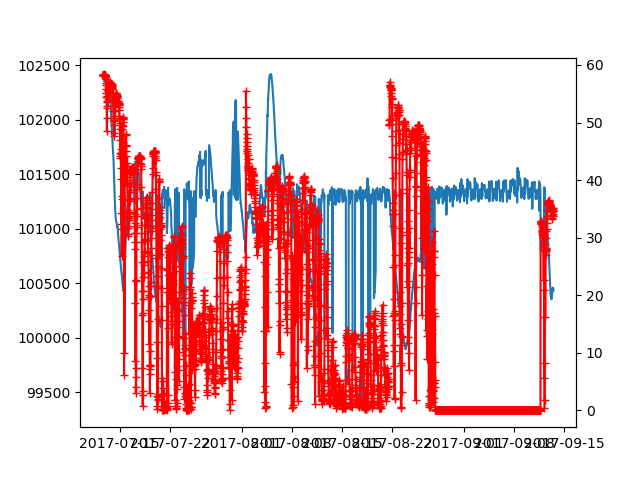

<IPython.core.display.Javascript object>


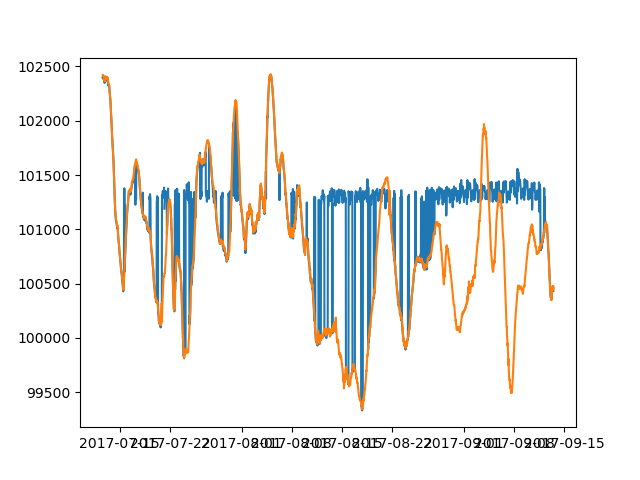

In [29]:
# plt.figure()
# plt.plot(Temp['co2_flux'])
# plt.plot(Data['co2_flux'])
# # plt.plot(Temp)

# plt.figure(figsize = (8,7))
# plt.plot(Temp['ch4_flux'])
# plt.plot(Data['ch4_flux'])#,marker = '+')
# # Temp2 = Data.copy()


# print(Data['co2_flux'].mean())
# print(Temp.mean())


# print(Data['co2_flux'].count())
# print(Temp.count())

# print(Data['ch4_flux'].mean())
# print(Temp2.mean())


# print(Data['ch4_flux'].count())
# print(Temp2.count())



FluxFolder='FluxResults/Pressure_Fix/'

TenHz_Path = Root+FluxFolder+'10Hz/eddypro_10Hz_full_output_2020-07-06T150723_exp.csv'
OneHz_Path = Root+FluxFolder+'1Hz/eddypro_1Hz_full_output_2020-07-03T202612_exp.csv'


Nu = pd.read_csv(TenHz_Path,
                  delimiter = ',',skiprows = 0,parse_dates={'datetime':[1,2]},header = 1,na_values = -9999)
Nu = Nu.iloc[1:]
Nu = Nu.set_index(pd.DatetimeIndex(Nu.datetime))
Nu[['ch4_flux','co2_flux','air_pressure','rssi_77_mean']] = Nu[['ch4_flux','co2_flux','air_pressure','rssi_77_mean']].astype(float)

FluxFolder='FluxResults/ProperWindSpeeds/'

TenHz_Path = Root+FluxFolder+'10Hz/eddypro_10Hz_full_output_2018-03-25T172145_adv.csv'
OneHz_Path = Root+FluxFolder+'1Hz/eddypro_1Hz_full_output_2018-03-25T142146_adv.csv'

Old = pd.read_csv(TenHz_Path,
                  delimiter = ',',skiprows = 0,parse_dates={'datetime':[1,2]},header = 1,na_values = -9999)
Old = Old.iloc[1:]
Old = Old.set_index(pd.DatetimeIndex(Old.datetime))
Old[['ch4_flux','co2_flux','air_pressure','rssi_77_mean']] = Old[['ch4_flux','co2_flux','air_pressure','rssi_77_mean']].astype(float)
# plt.figure()
# plt.scatter(Nu['ch4_flux'].values,Old['ch4_flux'].values)



plt.figure()
# plt.plot(Nu['air_pressure']-Old['air_pressure'])
plt.plot(Old['air_pressure'])

# plt.plot(Old['ch4_flux']*0+Old['air_pressure'].mean(),marker='+',color='red')
plt.twinx()
plt.plot(Old['rssi_77_mean'],marker='+',color='red')

# plt.figure()
# plt.scatter(Nu['co2_flux'].values,Old['co2_flux'].values)

# plt.figure()
# plt.scatter(Nu['air_pressure'].values,Old['air_pressure'].values)

# print(Nu['ch4_flux'].mean(),Old['ch4_flux'].mean())


# print(Nu['ch4_flux'].shape,Old['ch4_flux'].shape)


# plt.figure()


# plt.scatter(Nu.loc[np.abs(Nu['air_pressure']-Old['air_pressure'])<50,'co2_flux'],
#          Old.loc[np.abs(Nu['air_pressure']-Old['air_pressure'])<50,'co2_flux'])
# plt.scatter(Nu.loc[np.abs(Nu['air_pressure']-Old['air_pressure'])>50,'co2_flux'],
#          Old.loc[np.abs(Nu['air_pressure']-Old['air_pressure'])>50,'co2_flux'])

plt.figure()
# plt.plot(Nu['air_pressure']-Old['air_pressure'])
plt.plot(Old['air_pressure'])
plt.plot(Nu['air_pressure'])
# plt.yscale('symlog')

<IPython.core.display.Javascript object>


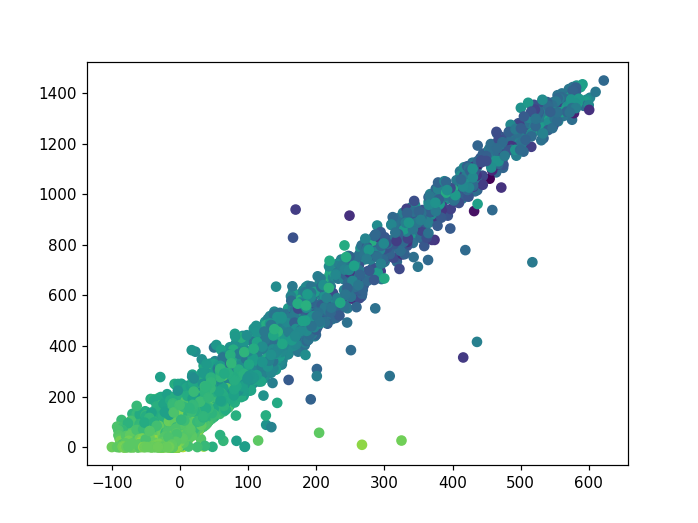

In [62]:
plt.figure()
plt.scatter(Data['NR_Wm2_Avg'],Data['PPFD_Avg'],c=Data['co2_flux'])
# x2=plt.twinx()
# x2.plot(Data['u*'],color='orange')

In [ ]:


from scipy.stats import pearsonr
plt.figure()
plt.scatter(Data['fch4']*1e-3 * 12.0107 *3600*24,Data['rssi_77_mean'])
print(Data['fch4'].mean()*1e-3 * 12.0107 *3600*24)

Temp = Data[['fch4','rssi_77_mean']].dropna()

# Temp = Temp.loc[Temp['rssi_77_mean']>20]
S,_ = pearsonr(Temp['fch4'].values,Temp['rssi_77_mean'].values)
print(S)

In [ ]:
# plt.figure()
# # Data.loc[((Data.index>'2017-7-10 12:00:00')&((Data.index<'2017-7-10 19:30:00'))),['Table_1','Table_2','Table_3',]]=np.nan
# # Data.loc[((Data.index>'2017-8-1 14:00:00')&((Data.index<'2017-8-1 22:00:00'))),['Table_1','Table_2','Table_3',]]=np.nan
# plt.plot(Data['Table_1'])
# # plt.plot(Data['Table_2'])
# # plt.plot(Data['Table_3'])
# x2=plt.twinx()
# x2.plot(Data['Total_Rain_mm_Tot'],c='g')
# before = Data.loc[((Data.index<'2017-7-10 12:00:00')&((Data.index>'2017-7-10 6:00:00'))),['Depth_3']].mean()
# after = Data.loc[((Data.index>'2017-7-10 14:30:00')&((Data.index<'2017-7-10 19:30:00'))),['Depth_3']].mean()
# print(after - before)

# '2017-8-1 15:00:00'
# before = Data.loc[((Data.index<'2017-8-1 14:00:00')&((Data.index>'2017-8-1 8:00:00'))),['Depth_3']].mean()
# after = Data.loc[((Data.index>'2017-8-1 16:00:00')&((Data.index<'2017-8-1 22:00:00'))),['Depth_3']].mean()
# print(after - before)

plt.figure()
# plt.scatter(Data['H'],Data['NR_Wm2_Avg'])
plt.scatter(Data['NR_Wm2_Avg'],Data['Net_Ttl_Rad_Avg'])
Temp = Data.loc[((np.isnan(Data['NR_Wm2_Avg'])==False)&(np.isnan(Data['Net_Ttl_Rad_Avg'])==False))]
print(metrics.r2_score(Temp['NR_Wm2_Avg'],Temp['Net_Ttl_Rad_Avg']))
def Curve(x,a,b):
    return(a*x+b)
p,r=curve_fit(Curve,Temp['Net_Ttl_Rad_Avg'],Temp['NR_Wm2_Avg'])
print(p)

In [ ]:

def AL(AL,a,b,c,d):
#     cv =.7
    return(a*AL**3+b*AL**2+AL*c+d)
#     return((MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5)/(2*cv))

from scipy.optimize import minimize, curve_fit


Comp.Data['DOY']=Comp.Data.index.dayofyear
Temp = Comp.Data[['Active_Layer_1','DOY']].resample('D').mean().round(2)
print(Temp.loc[Temp['Active_Layer_1']==.4])

popt_r, pcov = curve_fit(AL, Temp['Active_Layer_1'], Temp['DOY'])

plt.figure(figsize =(10,7))
plt.plot(np.arange(0,1,.05),AL(np.arange(0,1,.05),*popt_r))#*-1*100)
plt.scatter(Temp.Active_Layer_1,Temp['DOY'])
plt.grid()
plt.ylim(Temp['DOY'].min()-15,Temp['DOY'].max()+15)
plt.xlim(Temp['Active_Layer_1'].min()-.1,Temp['Active_Layer_1'].max()+.1)

print(AL(.0,*popt_r))
print(AL(.2,*popt_r))
print(AL(.3,*popt_r))

In [ ]:
plt.figure()
plt.plot(Data['Temp_2_5_2'])
plt.plot(Data['Temp_5_2'])
# plt.plot(Data['Temp_2_5_2'])
plt.plot(Data['Temp_15_2'])
# plt.plot(Data['Temp_5_2'])
plt.figure()
plt.scatter(Data['Temp_15_1'],Data['Temp_15_2'])
# ,'Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2'])

# plt.figure()
# plt.plot()
m = (Data['Temp_15_1'].mean()-Data['Temp_5_1'].mean())/10
Data['m'] = (Data['Temp_15_1']-Data['Temp_5_1'])/10
print(m)
X = np.arange(0,30)
b=(Data['Temp_5_1'].mean()-m*5)
print(b)
Data['b']=Data['Temp_5_1']-Temp['m']*5

# y = mx+b
# mx=y-b
# x=(y-b)/m
# y = m*X+b
plt.figure()
plt.plot((0-Data['b'])/Data['m'])
# plt.plot(X,y)
# plt.scatter(2.5,Data['Temp_2_5_1'].mean())
# plt.scatter(5,Data['Temp_5_1'].mean())
# plt.scatter(15,Data['Temp_15_1'].mean())

In [ ]:
def Curve(X,b,c):#,c,d):
    return(b*X+c)

#     return(-np.tanh(a*X+b)*c+d)
# def Curve(X,b):
#     return((b/X-10))
Y = np.array([[10,8,2],[10,8,3]])
plt.figure()
i = 0
Zp = []
Temp = Data[['Temp_2_5_2','Temp_5_2','Temp_15_2','Active_Layer_2']]#.resample('D').mean()
# print(Temp)
F = []
for d in Data.DOY.unique():
    y = Data.loc[Data.DOY==d,['Temp_2_5_1','Temp_5_1','Temp_15_1']].values#.flatten()
    X = np.array([np.array([2.5,5,15])for x in range(y.shape[0])]).flatten()
    y=y.flatten()
    try:
        p,z = curve_fit(Curve,X,y)
        z = np.arange(0,60)
        plt.plot(z,Curve(z,*p))
        plt.scatter(X,y)
        
        F.append(z[np.where(Curve(z,*p)<=-1)][0])
    except:
        pass
# Zp = np.array(Zp)
F = np.array(F)

# print(np.mean(F))
# print(np.std(F))

In [ ]:

plt.figure()
plt.plot(F)
plt.plot(Data['Active_Layer_1'].resample('D').mean().values*100)

In [ ]:

# def y(X,a=1,b=1,c=1,d=1):
# #     return(a*X**2+b*X+c)
# #     return(a*X**2+b*X+c)
#     return((a)**2*X**2+b*X+c)
#     return(-np.tanh(a*X+b)*c+d)
plt.figure()
plt.plot(Data['VWC_1'])
# plt.plot(Data['VWC_2'])
x2 = plt.twinx()
x2.plot(Data['Table_1'],color='g')
x2.plot(Data['Table_3'],color='y')
x2.plot(Data['Table_2'],color='r')